In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [10]:
upper_path = "../../dataset/DressCode/upper_body/images/"
lower_path = "../../dataset/DressCode/lower_body/images/"    


# Load image numbers list
img_list_upper = []
for img in os.listdir(upper_path):
    if img.endswith("0.jpg"):
        img_list_upper.append(img + " " + img.split("_")[0]+"_1.jpg")

img_list_lower = []
for img in os.listdir(lower_path):
    if img.endswith("0.jpg"):
        img_list_lower.append(img + " " + img.split("_")[0]+"_1.jpg")

In [11]:
print("Number of upper body images: ", len(img_list_upper))
print("Number of lower body images: ", len(img_list_lower))
print(img_list_upper)
print(img_list_lower)

Number of upper body images:  15363
Number of lower body images:  8946
['000000_0.jpg 000000_1.jpg', '000001_0.jpg 000001_1.jpg', '000002_0.jpg 000002_1.jpg', '000003_0.jpg 000003_1.jpg', '000004_0.jpg 000004_1.jpg', '000005_0.jpg 000005_1.jpg', '000006_0.jpg 000006_1.jpg', '000007_0.jpg 000007_1.jpg', '000008_0.jpg 000008_1.jpg', '000009_0.jpg 000009_1.jpg', '000010_0.jpg 000010_1.jpg', '000011_0.jpg 000011_1.jpg', '000012_0.jpg 000012_1.jpg', '000013_0.jpg 000013_1.jpg', '000014_0.jpg 000014_1.jpg', '000015_0.jpg 000015_1.jpg', '000016_0.jpg 000016_1.jpg', '000017_0.jpg 000017_1.jpg', '000018_0.jpg 000018_1.jpg', '000019_0.jpg 000019_1.jpg', '000020_0.jpg 000020_1.jpg', '000021_0.jpg 000021_1.jpg', '000022_0.jpg 000022_1.jpg', '000023_0.jpg 000023_1.jpg', '000024_0.jpg 000024_1.jpg', '000025_0.jpg 000025_1.jpg', '000026_0.jpg 000026_1.jpg', '000027_0.jpg 000027_1.jpg', '000028_0.jpg 000028_1.jpg', '000029_0.jpg 000029_1.jpg', '000030_0.jpg 000030_1.jpg', '000031_0.jpg 000031_1.jpg', 

In [12]:
with open('upper_images.txt', 'w') as f:
    for item in img_list_upper:
        f.write("%s\n" % item)

with open('lower_images.txt', 'w') as f:
    for item in img_list_lower:
        f.write("%s\n" % item)


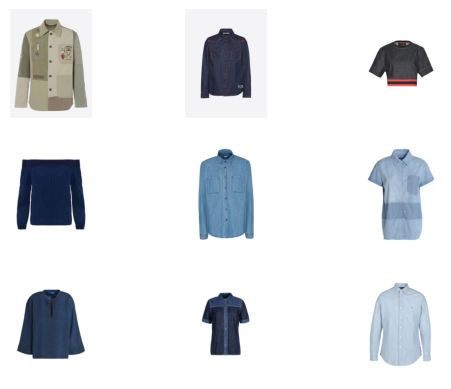

In [4]:
for i in range(3):
    for j in range(3):
        img = plt.imread(dataset_path + img_list[i*3+j])
        plt.subplot(3, 3, i*3+j+1)
        plt.axis('off')
        plt.imshow(img)

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomImageDataset(directory=dataset_path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [6]:
import torch
from torchvision.models import resnet50

# Initialize the pre-trained model
model = resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Adapt the model to use it as a feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1]))

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = model.to(device)

# Feature extraction function
def extract_features(dataloader, model, device):
    features = []
    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)  # Move input data to the GPU
            outputs = model(inputs).flatten(start_dim=1)
            features.append(outputs.cpu().numpy())  # Move the tensors back to CPU for numpy conversion
    return np.concatenate(features, axis=0)


c:\Users\user20\anaconda3\envs\hr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user20\anaconda3\envs\hr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
features = extract_features(dataloader, model, device)
np.save('../../upper_features.npy', features)

In [ ]:
"""# Extract features
features = extract_features(dataloader, model, device)
#save model
np.save('./features.npy', features)"""

In [26]:
features = np.load('./features.npy')

In [27]:
from sklearn.cluster import KMeans

# Clustering
kmeans = KMeans(n_clusters=40, random_state=22)
clusters = kmeans.fit_predict(features)

d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [28]:
print(len(clusters))
print(clusters)

11647
[ 8 11 29 ... 34  2  9]


In [29]:
cluster_groups = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i, cluster in enumerate(clusters):
    if cluster not in cluster_groups:
        cluster_groups[cluster] = []
    cluster_groups[cluster].append(img_list[i])

In [30]:
print(cluster_groups.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 29, 10, 27, 25, 14, 21, 39, 34, 16, 17, 37, 20, 31, 22, 15, 30, 19, 13, 23, 33, 28, 38, 36, 18, 12, 32, 35, 24, 26])


In [31]:
def print_cluster_img(num):
    for i in range(10):
        img = plt.imread(dataset_path + cluster_groups[num][i])
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(img)

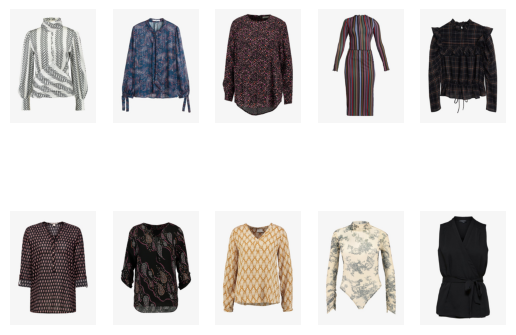

In [32]:
print_cluster_img(0)

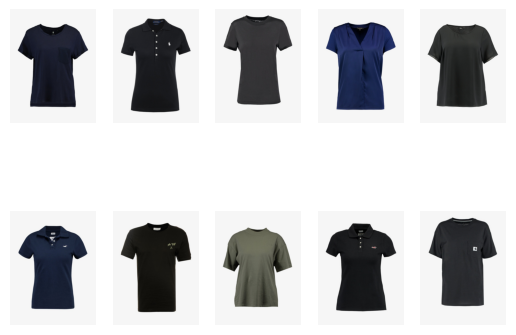

In [33]:
print_cluster_img(1)

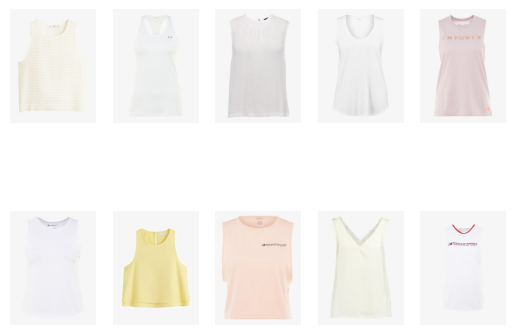

In [34]:
print_cluster_img(2)

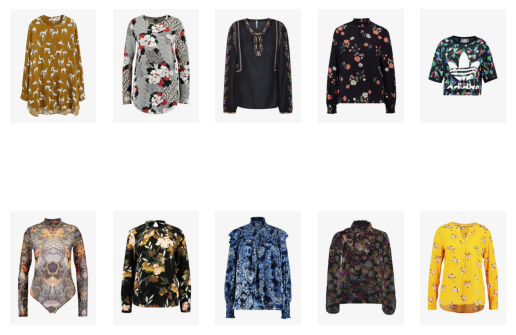

In [35]:
print_cluster_img(3)

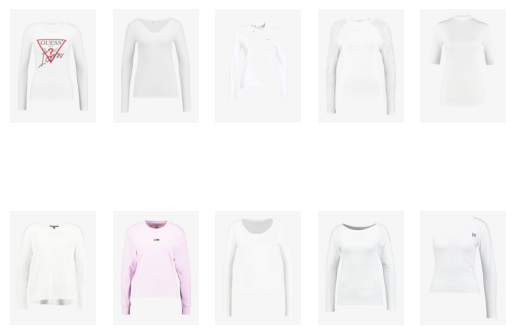

In [36]:
print_cluster_img(4)

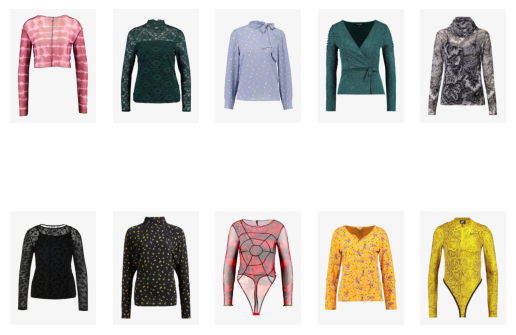

In [37]:
print_cluster_img(5)

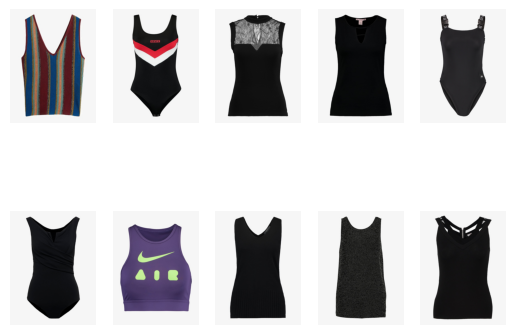

In [38]:
print_cluster_img(6)

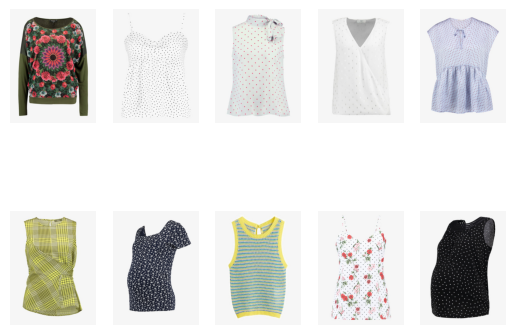

In [39]:
print_cluster_img(7)

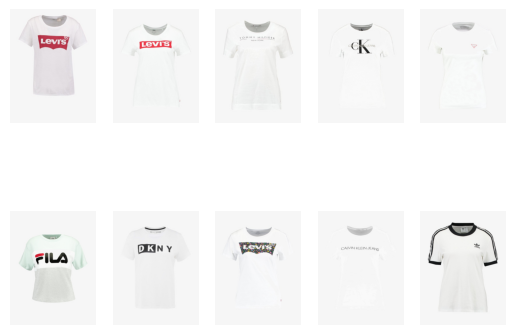

In [40]:
print_cluster_img(8)

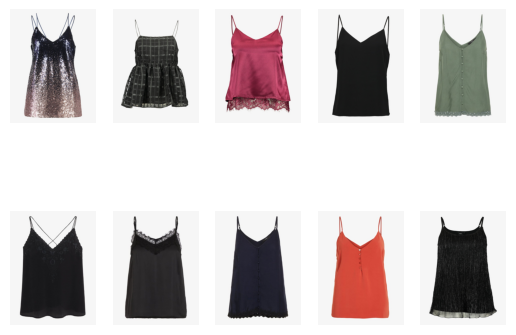

In [41]:
print_cluster_img(9)

### Predict

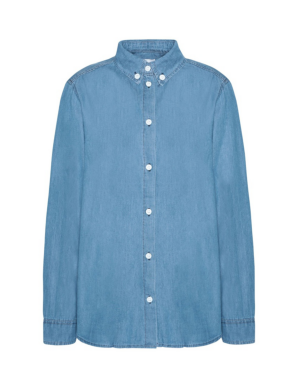

Test Image Cluster: [5]


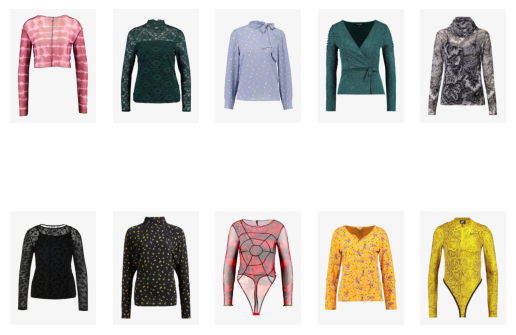

In [54]:
test_img = plt.imread("../dataset/cloth/upper_body/000029_1.jpg")

test_img_transformed = transform(Image.fromarray(test_img))
test_img_feature = model(test_img_transformed.unsqueeze(0).to(device)).flatten(start_dim=1).detach().cpu().numpy()
# Plot the test image
plt.imshow(test_img)
plt.axis('off')
plt.show()

# Predict the cluster for the test image
test_cluster = kmeans.predict(test_img_feature)
print("Test Image Cluster:", test_cluster)

# Plot the images in the same cluster as the test image
print_cluster_img(test_cluster[0])


In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import torch

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from torchvision.models import resnet50
from sklearn.cluster import KMeans
import json
import io
from tqdm.auto import tqdm

from sklearn.metrics.pairwise import euclidean_distances

def initialize(**kwargs):
    print("\n--- Initialize Clustering ---\n")
    
    SETTINGS = argparse.Namespace(**kwargs)
    upper_path = SETTINGS.dataset_path + "/upper_body/"
    # lower_path = SETTINGS.dataset_path + "/lower_body/"
    
    # Load image numbers list
    img_list_upper = []
    for img in tqdm(os.listdir(upper_path)):
        if img.endswith("1.jpg"):
            img_list_upper.append(img)

    # img_list_lower = []
    # for img in os.listdir(lower_path):
    #     if img.endswith("1.jpg"):
    #         img_list_lower.append(img)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3), # convert to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Initialize the pre-trained model
    model = resnet50(pretrained=True)
    model.eval()  # Set the model to evaluation mode

    # Adapt the model to use it as a feature extractor
    model = torch.nn.Sequential(*(list(model.children())[:-1]))

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model = model.to(device)

    # Load the features
    features_upper = np.load(SETTINGS.upper_model_path)
    # features_lower = np.load(SETTINGS.lower_model_path)

    # Clustering
    kmeans_upper = KMeans(n_clusters=100, random_state=22)
    kmeans_upper.fit_predict(features_upper)

    # kmeans_lower = KMeans(n_clusters=100, random_state=22)
    # kmeans_lower.fit_predict(features_lower)

    # Load the cluster groups dict back from the JSON file
    with open(SETTINGS.cluster_upper_result_path, 'r') as json_file:
        cluster_groups_upper = json.load(json_file)
    # with open(SETTINGS.cluster_lower_result_path, 'r') as json_file:
    #     cluster_groups_lower = json.load(json_file)

    return {
        'device': device,
        'img_list_upper': img_list_upper,
        # 'img_list_lower': img_list_lower,
        'transform': transform,
        'model': model,
        'features_upper': features_upper,
        'kmeans_upper': kmeans_upper,
        'cluster_groups_upper': cluster_groups_upper,
        # 'features_lower': features_lower,
        # 'kmeans_lower': kmeans_lower,
        # 'cluster_groups_lower': cluster_groups_lower
    }

def convert_png_to_jpg_if_needed(img_path):
    # 파일 확장자 확인
    filename, file_extension = os.path.splitext(img_path)
    if file_extension.lower() == '.png':
        # PNG 이미지를 열기
        png_image = Image.open(img_path)
        # RGB 모드로 변환하고 투명도를 흰색 배경으로 대체
        if png_image.mode in ('RGBA', 'LA'):
            # 투명도 채널 확인 및 흰색 배경 이미지 생성
            background = Image.new('RGB', png_image.size, (255, 255, 255))
            # PNG 이미지 위에 흰색 배경 합성
            background.paste(png_image, mask=png_image.split()[3])  # 3은 알파 채널
            png_image = background
        # JPG 파일로 저장 (임시 파일 이름 생성)
        # jpg_img_path = filename + '_white_bg.jpg' # 범순
        # jpg_img_path = '.\\images\\input\\ladi_vton\\upper_body\\1.jpg'
        # png_image.save(jpg_img_path, 'JPEG', quality=90)
        # JPEG로 변환하기 (저장하지 않음)
        jpg_image_bytes = io.BytesIO()
        png_image.convert("RGB").save(jpg_image_bytes, format="JPEG")
        # JPEG 이미지 바이트로 변환된 것 확인
        jpg_image_bytes.seek(0)
        jpg_image_data = jpg_image_bytes.getvalue()
        jpg_img_path = plt.imread(jpg_image_data)
        # print('convert png to jpg with white background')
        
        return jpg_img_path
    else:
        # 이미지 경로가 PNG가 아닐 경우 원본 경로 반환
        # 이미지 출력
        img = plt.imread(img_path)
        return img
    
def run_inference(is_upper, img_path, INIT_VARS=None):
    transform = INIT_VARS['transform']
    model = INIT_VARS['model']
    device = INIT_VARS['device']
    
    if is_upper: # upper body
        img_list = INIT_VARS['img_list_upper']
        features = INIT_VARS['features_upper']
        kmeans = INIT_VARS['kmeans_upper']
        cluster_groups = INIT_VARS['cluster_groups_upper']
        
    else: # lower body
        img_list = INIT_VARS['img_list_lower']
        features = INIT_VARS['features_lower']
        kmeans = INIT_VARS['kmeans_lower']
        cluster_groups = INIT_VARS['cluster_groups_lower']
    
    # test_img = plt.imread(img_path)
    jpg_img_path = convert_png_to_jpg_if_needed(img_path)
    # 변환된 JPG 이미지 읽기
    test_img = jpg_img_path # plt.imread(jpg_img_path)

    test_img_transformed = transform(Image.fromarray(test_img))
    test_img_feature = model(test_img_transformed.unsqueeze(0).to(device)).flatten(start_dim=1).detach().cpu().numpy()

    # Predict the cluster for the test image
    test_cluster = kmeans.predict(test_img_feature) # predict the cluster number for the test image
    # test image 클러스터에 속하는 이미지들의 파일명
    test_cluster_img_list = cluster_groups[str(test_cluster[0])]                ### TODO
    test_cluster_img_idx_list = [i for i, j in enumerate(img_list) if j in test_cluster_img_list]

    ### 유클리디안 거리로 유사도 계산
    reference_feature = test_img_feature  # 기준 이미지의 특징 벡터
    cluster_features = features[test_cluster_img_idx_list]    # test 클러스터 내 모든 이미지의 특징 벡터

    # 유클리디안 거리 계산
    distances = euclidean_distances(reference_feature, cluster_features)[0]

    # 유클리디안 거리가 가까운순으로 index 정렬
    sorted_indices = np.argsort(distances)  # 오름차순으로 정렬

    # 거리가 가장 가까운 순서대로 test cluster 내 이미지 정렬한 이미지 리스트
    test_cluster_img_list = np.array(test_cluster_img_list)

    # 정렬된 인덱스를 사용하여 예측된 클러스터에 유사한 이미지 순서대로 접근

    # 정렬된 인덱스를 사용하여 유사한 이미지 순서대로 접근
    sorted_images_list = test_cluster_img_list[sorted_indices]

    return {
        'sorted_images_list': sorted_images_list
    }


CLUSTER_SETTINGS = {
            "dataset_path" : "..\\..\\data\\cloth",
            "upper_model_path" : "..\\..\\upper_features.npy",
            # "lower_model_path" : ".\\clustering\\model\\features_grey_lower.npy",
            "cluster_upper_result_path" : "cluster_result_upper.json",
            # "cluster_lower_result_path" : ".\\clustering\\cluster_result_lower.json",
        }
a = run_inference(True, "../../data/cloth/upper_body/000001_1.jpg", INIT_VARS=initialize(**CLUSTER_SETTINGS))
print(a)


--- Initialize Clustering ---



  0%|          | 0/15363 [00:00<?, ?it/s]

c:\Users\user20\anaconda3\envs\hr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user20\anaconda3\envs\hr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\user20\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'sorted_images_list': array(['003010_1.jpg', '003135_1.jpg', '049621_1.jpg', '012185_1.jpg',
       '012093_1.jpg', '002318_1.jpg', '005243_1.jpg', '049241_1.jpg',
       '001921_1.jpg', '050083_1.jpg', '048484_1.jpg', '005900_1.jpg',
       '010610_1.jpg', '001502_1.jpg', '000174_1.jpg', '002898_1.jpg',
       '006889_1.jpg', '049079_1.jpg', '050023_1.jpg', '049856_1.jpg',
       '011149_1.jpg', '007177_1.jpg', '000750_1.jpg', '002829_1.jpg',
       '049614_1.jpg', '000332_1.jpg', '002707_1.jpg', '001372_1.jpg',
       '006646_1.jpg', '003136_1.jpg', '003506_1.jpg', '011563_1.jpg',
       '010337_1.jpg', '049624_1.jpg', '012685_1.jpg', '002897_1.jpg',
       '012854_1.jpg', '048901_1.jpg', '008491_1.jpg', '008487_1.jpg',
       '001593_1.jpg', '001778_1.jpg', '011041_1.jpg', '003315_1.jpg',
       '006497_1.jpg', '003094_1.jpg', '001741_1.jpg', '049109_1.jpg',
       '012214_1.jpg', '008528_1.jpg', '003323_1.jpg', '007020_1.jpg',
       '006359_1.jpg', '004839_1.jpg', '002304_1.jpg',